In [1]:
# I decided to treat this as a classification problem by creating a new binary 
# variable affair (did the woman have at least one affair?) and trying to
# predict the classification for each woman.

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score

In [3]:
dta = sm.datasets.fair.load_pandas().data
dta

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666
...,...,...,...,...,...,...,...,...,...
6361,5.0,32.0,13.0,2.0,3.0,17.0,4.0,3.0,0.000000
6362,4.0,32.0,13.0,1.0,1.0,16.0,5.0,5.0,0.000000
6363,5.0,22.0,2.5,0.0,2.0,14.0,3.0,1.0,0.000000
6364,5.0,32.0,6.0,1.0,3.0,14.0,3.0,4.0,0.000000


In [4]:
dta['affairs'] = (dta.affairs > 0).astype(int)
dta

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,1
...,...,...,...,...,...,...,...,...,...
6361,5.0,32.0,13.0,2.0,3.0,17.0,4.0,3.0,0
6362,4.0,32.0,13.0,1.0,1.0,16.0,5.0,5.0,0
6363,5.0,22.0,2.5,0.0,2.0,14.0,3.0,1.0,0
6364,5.0,32.0,6.0,1.0,3.0,14.0,3.0,4.0,0


In [5]:
dta.groupby('affairs').mean()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb
affairs,,,,,,,,
0,4.329701,28.390679,7.989335,1.238813,2.504521,14.322977,3.405286,3.833758
1,3.647345,30.537019,11.152460,1.728933,2.261568,13.972236,3.463712,3.884559


In [6]:
dta.groupby('rate_marriage').mean()

,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
rate_marriage,,,,,,,,
1.0,33.823232,13.914141,2.308081,2.343434,13.848485,3.232323,3.838384,0.747475
2.0,30.471264,10.727011,1.735632,2.330460,13.864943,3.327586,3.764368,0.635057
3.0,30.008056,10.239174,1.638469,2.308157,14.001007,3.402820,3.798590,0.550856
4.0,28.856601,8.816905,1.369536,2.400981,14.144514,3.420161,3.835861,0.322926
5.0,28.574702,8.311662,1.252794,2.506334,14.399776,3.454918,3.892697,0.181446


Text(0, 0.5, 'Frequency')

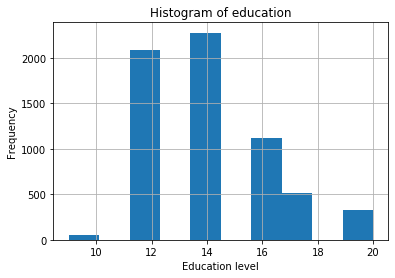

In [7]:
%matplotlib inline
dta.educ.hist()
plt.title("Histogram of education")
plt.xlabel("Education level")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

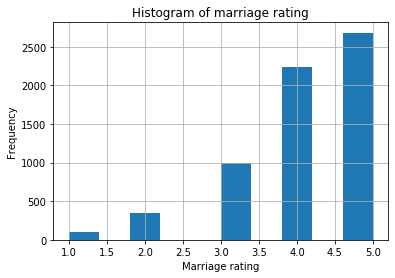

In [8]:
dta.rate_marriage.hist()
plt.title("Histogram of marriage rating")
plt.xlabel("Marriage rating")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

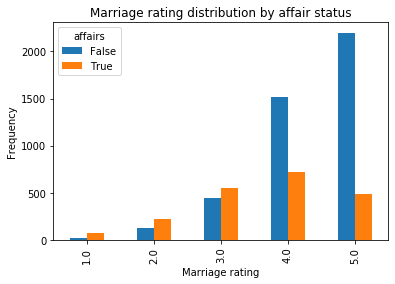

In [9]:
pd.crosstab(dta.rate_marriage, dta.affairs.astype(bool)).plot(kind="bar")
plt.title("Marriage rating distribution by affair status")
plt.xlabel("Marriage rating")
plt.ylabel("Frequency")

Text(0, 0.5, 'Percentage')

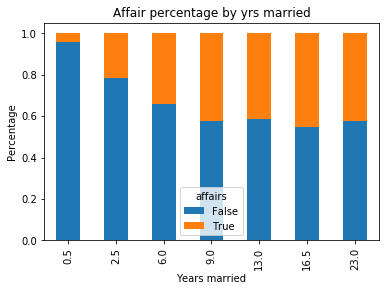

In [10]:
affairs_yrs_married = pd.crosstab(dta.yrs_married, dta.affairs.astype(bool))
affairs_yrs_married.div(affairs_yrs_married.sum(1).astype(float), axis=0).plot(kind='bar', stacked = True)
plt.title("Affair percentage by yrs married")
plt.xlabel("Years married")
plt.ylabel("Percentage")

In [11]:
y, X = dmatrices('affairs ~ rate_marriage + age + yrs_married + children + religious + educ + \
                    C(occupation) + C(occupation_husb)', dta, return_type="dataframe")
print(X.columns)

Index(['Intercept', 'C(occupation)[T.2.0]', 'C(occupation)[T.3.0]',
       'C(occupation)[T.4.0]', 'C(occupation)[T.5.0]', 'C(occupation)[T.6.0]',
       'C(occupation_husb)[T.2.0]', 'C(occupation_husb)[T.3.0]',
       'C(occupation_husb)[T.4.0]', 'C(occupation_husb)[T.5.0]',
       'C(occupation_husb)[T.6.0]', 'rate_marriage', 'age', 'yrs_married',
       'children', 'religious', 'educ'],
      dtype='object')


In [12]:
X = X.rename(columns = {'C(occupation)[T.2.0]':'occ_2',
                        'C(occupation)[T.3.0]':'occ_3',
                        'C(occupation)[T.4.0]':'occ_4',
                        'C(occupation)[T.5.0]':'occ_5',
                        'C(occupation)[T.6.0]':'occ_6',
                        'C(occupation_husb)[T.2.0]':'occ_husb_2',
                        'C(occupation_husb)[T.3.0]':'occ_husb_3',
                        'C(occupation_husb)[T.4.0]':'occ_husb_4',
                        'C(occupation_husb)[T.5.0]':'occ_husb_5',
                        'C(occupation_husb)[T.6.0]':'occ_husb_6'})

In [13]:
y = np.ravel(y)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=5)
logReg = LogisticRegression()
logReg.fit(x_train, y_train)

C:\Users\syaam\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
#From here i implemented as mentioned in ineuron logistic regression

In [16]:
y_pred = logReg.predict(x_test)

In [17]:
accuracy = accuracy_score(y_test,y_pred)
accuracy

0.7229199372056515

In [18]:
conf_mat = confusion_matrix(y_test,y_pred)
conf_mat

array([[778, 103],
       [250, 143]], dtype=int64)

In [19]:
true_positive = conf_mat[0][0]
false_positive = conf_mat[0][1]
false_negative = conf_mat[1][0]
true_negative = conf_mat[1][1]

In [20]:
Accuracy = (true_positive + true_negative) / (true_positive +false_positive + false_negative + true_negative)
Precision = true_positive/(true_positive+false_positive)
Recall = true_positive/(true_positive+false_negative)
F1_Score = 2*(Recall * Precision) / (Recall + Precision)
print("Accuracy = ", Accuracy)
print("Precision = ", Precision)
print("Recall = ",Recall)
print("F1_Score = ", F1_Score)

Accuracy =  0.7229199372056515
Precision =  0.8830874006810443
Recall =  0.7568093385214008
F1_Score =  0.8150864326872709


In [21]:
auc = roc_auc_score(y_test, y_pred)
auc

0.6234775425797079

In [22]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

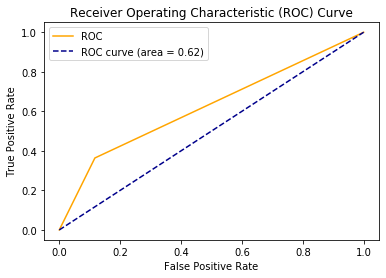

In [23]:
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [24]:
import pickle
filename = 'Log_reg_assignment.pickle'
pickle.dump(logReg, open(filename,'wb'))

In [25]:
X

,Intercept,occ_2,occ_3,occ_4,occ_5,occ_6,occ_husb_2,occ_husb_3,occ_husb_4,occ_husb_5,occ_husb_6,rate_marriage,age,yrs_married,children,religious,educ
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,32.0,9.0,3.0,3.0,17.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,27.0,13.0,3.0,1.0,14.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,22.0,2.5,0.0,1.0,16.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,37.0,16.5,4.0,3.0,16.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,27.0,9.0,1.0,1.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6361,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,32.0,13.0,2.0,3.0,17.0
6362,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,32.0,13.0,1.0,1.0,16.0
6363,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,22.0,2.5,0.0,2.0,14.0
6364,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,32.0,6.0,1.0,3.0,14.0


In [26]:
y

array([1., 1., 1., ..., 0., 0., 0.])

In [27]:
ddf = pd.DataFrame(zip(X.index, y))
ddf

,0,1
0,0,1.0
1,1,1.0
2,2,1.0
3,3,1.0
4,4,1.0
...,...,...
6361,6361,0.0
6362,6362,0.0
6363,6363,0.0
6364,6364,0.0


In [28]:
loaded_model = pickle.load(open(filename,'rb'))

In [29]:
#Just passing the same input params from input dataset direct to the model
#And also compare whether the original predicted value and the value predicted by my model is same or nearly same 

In [30]:
indexOfDataToPassToModel = 6364
a = X.iloc[indexOfDataToPassToModel].values.tolist()
b = loaded_model.predict([a])

print ("original dataset y val", ddf.iloc[indexOfDataToPassToModel][1])
print ("predicted dataset y val", b)

original dataset y val 0.0
predicted dataset y val [0.]
